In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#Load the datasets
purchase_behavior = pd.read_csv('QVI_purchase_behaviour.csv')
transactions = pd.read_csv('QVI_transaction_data.csv')

In [3]:
#Explore the datasets
purchase_behavior.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [4]:
transactions.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [5]:
purchase_behavior.shape

(72637, 3)

In [6]:
transactions.shape #Already we can see there are more transactions than customers
#so we can infer that on a per-customer basis, they are buying multi-packs of chips 

(264836, 8)

In [7]:
#Let's check for nulls
purchase_behavior.isnull().any()

LYLTY_CARD_NBR      False
LIFESTAGE           False
PREMIUM_CUSTOMER    False
dtype: bool

In [8]:
transactions.isnull().any()

DATE              False
STORE_NBR         False
LYLTY_CARD_NBR    False
TXN_ID            False
PROD_NBR          False
PROD_NAME         False
PROD_QTY          False
TOT_SALES         False
dtype: bool

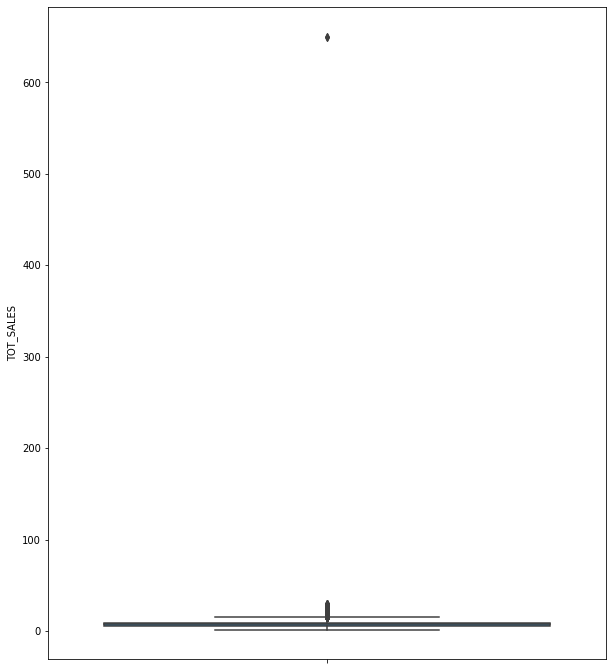

In [9]:
#Finding any outliers in the transactions data via a boxplot
plt.figure(figsize=(10,12))
ax = sns.boxplot(y = 'TOT_SALES', data = transactions)
#Clearly there is an outlier 

In [10]:
#Finding this outlier in TOT_SALES
transactions[transactions['TOT_SALES'] == transactions['TOT_SALES'].max()]
#The two outliers are for different dates, but the same loyalty card number which bought 200 Dorito Corn Chp for $650
#Most likely this is a commerical purchase

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,43331,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,43605,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [11]:
#Let's remove the outlier code
new_transactions = transactions.loc[transactions['TOT_SALES'] != transactions['TOT_SALES'].max()]

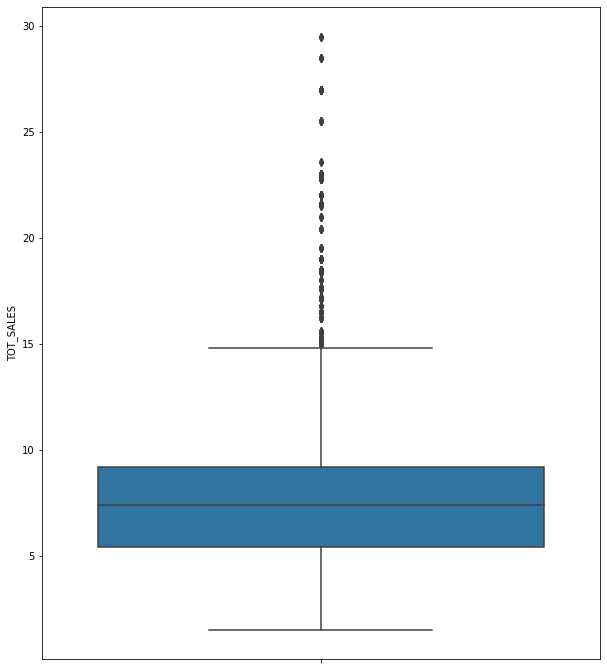

In [12]:
plt.figure(figsize = (10,12))
ax = sns.boxplot(y = 'TOT_SALES', data = new_transactions)
#That is a much cleaner graph

In [13]:
new_transactions.quantile([0.25,0.5, 0.75, 0.99])

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
0.25,43373.0,70.0,70021.0,67600.50,28.0,2.0,5.4
0.50,43464.0,130.0,130357.0,135136.50,56.0,2.0,7.4
0.75,43555.0,203.0,203094.0,202699.75,85.0,2.0,9.2
0.99,43643.0,270.0,270142.0,267517.67,114.0,2.0,13.0


In [14]:
new_transactions[new_transactions['TOT_SALES'] >= 25]
#I have a hunch that the max quantity for PROD_QTY is 5

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
72,43331,96,96203,96025,7,Smiths Crinkle Original 330g,5,28.5
5107,43329,54,54225,48172,46,Kettle Original 175g,5,27.0
5160,43600,82,82189,81669,46,Kettle Original 175g,5,27.0
5179,43327,94,94148,93390,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5
16977,43602,71,71108,69638,102,Kettle Mozzarella Basil & Pesto 175g,5,27.0
...,...,...,...,...,...,...,...,...
216998,43331,65,65095,62066,57,Old El Paso Salsa Dip Tomato Mild 300g,5,25.5
228515,43331,36,36221,32861,88,Kettle Honey Soy Chicken 175g,5,27.0
237879,43332,60,60198,56992,46,Kettle Original 175g,5,27.0
238140,43326,143,143279,143732,59,Old El Paso Salsa Dip Tomato Med 300g,5,25.5


In [15]:
new_transactions[new_transactions['TOT_SALES'] == new_transactions['TOT_SALES'].max()]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
5179,43327,94,94148,93390,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5
55558,43599,190,190113,190914,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5
69496,43327,49,49303,45789,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5
117850,43604,194,194308,194516,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5
150683,43605,118,118021,120799,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5
171815,43329,24,24095,20797,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5
184969,43605,44,44350,40394,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5


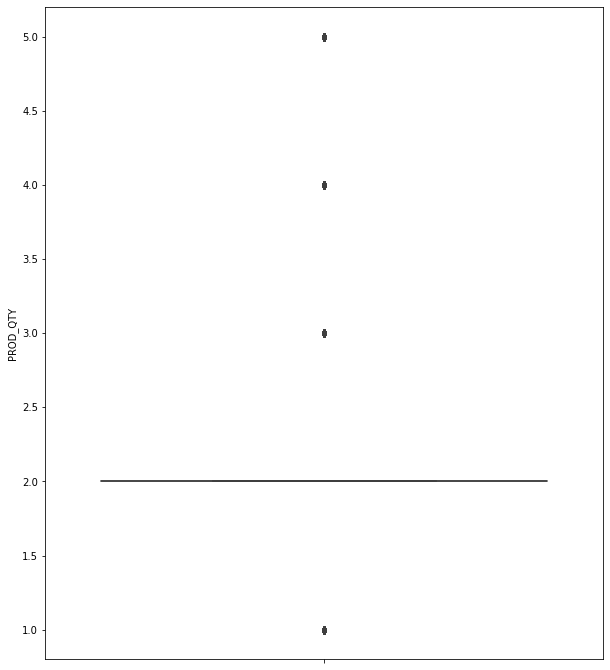

In [16]:
plt.figure(figsize=(10,12))
ax = sns.boxplot(y='PROD_QTY', data = new_transactions)
#PROD_QTY has very discrete numbers 

In [17]:
new_transactions[new_transactions['PROD_NAME'] == 'Kettle Tortilla ChpsHny&Jlpno Chili 150g']

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
24,43327,38,38142,34181,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,2,9.2
58,43331,75,75186,74168,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,2,9.2
129,43327,173,173154,174550,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,2,9.2
169,43600,226,226133,226926,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,1,4.6
...,...,...,...,...,...,...,...,...
263944,43382,234,234180,237560,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,2,9.2
263997,43528,236,236202,239790,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,2,9.2
264015,43393,237,237258,241288,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,2,9.2
264016,43550,237,237258,241289,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,2,9.2


In [18]:
new_transactions.groupby(['PROD_NAME'])['TOT_SALES', 'PROD_QTY'].agg(['mean', 'min', 'max', 'count'])
#High-level overview of chip sales and quantity based on the producer

TOT_SALES                   PROD_QTY  \
                                            mean  min   max count      mean   
PROD_NAME                                                                     
Burger Rings 220g                       4.367647  2.3  11.5  1564  1.898977   
CCs Nacho Cheese    175g                3.979907  2.1  10.5  1498  1.895194   
CCs Original 175g                       3.994716  2.1  10.5  1514  1.902246   
CCs Tasty Cheese    175g                3.943470  2.1  10.5  1539  1.877843   
Cheetos Chs & Bacon Balls 190g          6.249696  3.3  16.5  1479  1.893847   
...                                          ...  ...   ...   ...       ...   
WW Sour Cream &OnionStacked Chips 160g  3.589885  1.9   9.5  1483  1.889413   
WW Supreme Cheese   Corn Chips 200g     3.572101  1.9   9.5  1509  1.880053   
Woolworths Cheese   Rings 190g          3.410026  1.8   9.0  1516  1.894459   
Woolworths Medium   Salsa 300g          2.832168  1.5   7.5  1430  1.888112   
Woolworths Mild     Salsa 300g          2.840040  1.5   7.5  1491  1.893360   

                                                      
                                       min max count  
PROD_NAME                                             
Burger Rings 220g                        1   5  1564  
CCs Nacho Cheese    175g                 1   5  1498  
CCs Original 175g                        1   5  1514  
CCs Tasty Cheese    175g                 1   5  1539  
Cheetos Chs & Bacon Balls 190g           1   5  1479  
...                                     ..  ..   ...  
WW Sour Cream &OnionStacked Chips 160g   1   5  1483  
WW Supreme Cheese   Corn Chips 200g      1   5  1509  
Woolworths Cheese   Rings 190g           1   5  1516  
Woolworths Medium   Salsa 300g           1   5  1430  
Woolworths Mild     Salsa 300g           1   5  1491  

[114 rows x 8 columns]

In [19]:
#Let's just look at the chip producers
only_chips_transactions = new_transactions[new_transactions['PROD_NAME'].str.contains('Chps') | new_transactions['PROD_NAME'].str.contains('Chips')]
only_chips_transactions

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
6,43601,4,4149,3333,16,Smiths Crinkle Chips Salt & Vinegar 330g,1,5.7
10,43602,7,7215,7176,16,Smiths Crinkle Chips Salt & Vinegar 330g,1,5.7
14,43600,19,19272,16686,44,Thins Chips Light& Tangy 175g,1,3.3
...,...,...,...,...,...,...,...,...
264815,43408,271,271193,269365,33,Cobs Popd Swt/Chlli &Sr/Cream Chips 110g,2,7.6
264816,43614,271,271193,269366,75,Cobs Popd Sea Salt Chips 110g,2,7.6
264824,43537,272,272193,269906,9,Kettle Tortilla ChpsBtroot&Ricotta 150g,1,4.6
264826,43549,272,272194,269908,75,Cobs Popd Sea Salt Chips 110g,2,7.6


In [20]:
#Before merging let's take a quick look at the customer demographics
purchase_behavior['LIFESTAGE'].unique()
#There are 7 different unique Lifestage customers

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

In [21]:
purchase_behavior['LIFESTAGE'].value_counts()
#Retirees are the most number 

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

In [22]:
purchase_behavior['PREMIUM_CUSTOMER'].unique()
#There are 3 different types of premium customers

array(['Premium', 'Mainstream', 'Budget'], dtype=object)

In [23]:
purchase_behavior['PREMIUM_CUSTOMER'].value_counts()
#The majority of customers are mainstream

Mainstream    29245
Budget        24470
Premium       18922
Name: PREMIUM_CUSTOMER, dtype: int64

In [24]:
segmented_customers = purchase_behavior.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).agg(['count']).reset_index().sort_values(by= [('LYLTY_CARD_NBR', 'count')], ascending = False)
segmented_customers
#Sorted using a multi-level index!
#There are the greatest number of mainstream young singles/couples, mainstream retirees, and mainstream older singles/couples

,PREMIUM_CUSTOMER,LIFESTAGE,LYLTY_CARD_NBR
,,,count
13,Mainstream,YOUNG SINGLES/COUPLES,8088
11,Mainstream,RETIREES,6479
10,Mainstream,OLDER SINGLES/COUPLES,4930
3,Budget,OLDER SINGLES/COUPLES,4929
17,Premium,OLDER SINGLES/COUPLES,4750
2,Budget,OLDER FAMILIES,4675
4,Budget,RETIREES,4454
5,Budget,YOUNG FAMILIES,4017
18,Premium,RETIREES,3872


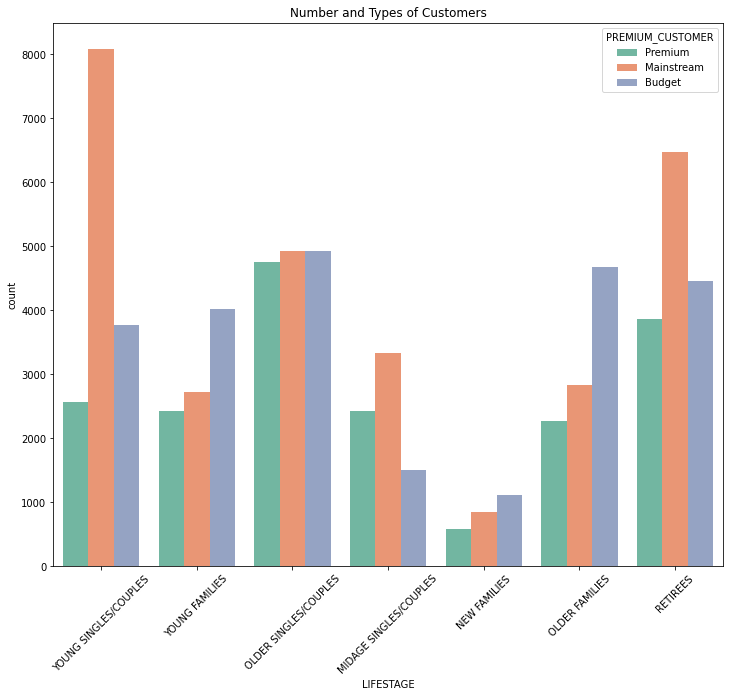

In [25]:
#Let's plot the customer types 
plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
plt.title('Number and Types of Customers')
ax = sns.countplot(x='LIFESTAGE', data=purchase_behavior,hue= 'PREMIUM_CUSTOMER', palette = 'Set2')

In [26]:
#All right, let's merge them based on Loyalty Card Number
merged = pd.merge(purchase_behavior, only_chips_transactions, left_on = 'LYLTY_CARD_NBR', right_on = 'LYLTY_CARD_NBR', how = 'inner')
merged['PRICE'] = merged['TOT_SALES'] / merged['PROD_QTY']
merged

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PRICE
0,1004,OLDER SINGLES/COUPLES,Mainstream,43406,1,5,96,WW Original Stacked Chips 160g,1,1.9,1.9
1,1011,OLDER SINGLES/COUPLES,Mainstream,43453,1,15,1,Smiths Crinkle Cut Chips Barbecue 170g,1,2.9,2.9
2,1027,OLDER FAMILIES,Premium,43325,1,35,16,Smiths Crinkle Chips Salt & Vinegar 330g,1,5.7,5.7
3,1034,RETIREES,Premium,43548,1,38,75,Cobs Popd Sea Salt Chips 110g,1,3.8,3.8
4,1043,YOUNG FAMILIES,Budget,43512,1,49,40,Thins Chips Seasonedchicken 175g,1,3.3,3.3
...,...,...,...,...,...,...,...,...,...,...,...
59345,2330051,RETIREES,Premium,43350,77,236719,78,Thins Chips Salt & Vinegar 175g,2,6.6,3.3
59346,2330081,RETIREES,Mainstream,43638,77,236723,30,Doritos Corn Chips Cheese Supreme 170g,2,8.8,4.4
59347,2370581,OLDER SINGLES/COUPLES,Budget,43460,88,240318,9,Kettle Tortilla ChpsBtroot&Ricotta 150g,2,9.2,4.6
59348,2370751,YOUNG FAMILIES,Premium,43374,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,4.6


In [27]:
merged.shape

(59350, 11)

In [28]:
merged.describe()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,PRICE
count,5.935000e+04,59350.000000,59350.000000,59350.000000,59350.000000,59350.000000,59350.000000,59350.000000
mean,1.360226e+05,43463.979697,135.611356,135687.453058,46.677203,1.907801,7.083008,3.708664
std,7.971178e+04,105.486283,76.834821,78058.281966,31.900968,0.337382,2.197101,0.930630
min,1.004000e+03,43282.000000,1.000000,5.000000,1.000000,1.000000,1.900000,1.320000
25%,7.012800e+04,43373.000000,70.000000,68226.250000,22.000000,2.000000,5.800000,3.300000
50%,1.330145e+05,43463.000000,133.000000,136020.500000,40.000000,2.000000,6.600000,3.800000
75%,2.032510e+05,43555.000000,203.000000,203330.500000,75.000000,2.000000,8.800000,4.400000
max,2.373711e+06,43646.000000,272.000000,270209.000000,110.000000,5.000000,28.500000,5.700000


In [29]:
#Again let's check for nulls
merged.isnull().any()

LYLTY_CARD_NBR      False
LIFESTAGE           False
PREMIUM_CUSTOMER    False
DATE                False
STORE_NBR           False
TXN_ID              False
PROD_NBR            False
PROD_NAME           False
PROD_QTY            False
TOT_SALES           False
PRICE               False
dtype: bool

In [30]:
null_columns = ['DATE', 'STORE_NBR', 'TXN_ID', 'PROD_NBR', 'PROD_NAME', 'PROD_QTY', 'TOT_SALES', 'PRICE']
merged[null_columns].isnull().sum()
#There is actually one null value 

DATE         0
STORE_NBR    0
TXN_ID       0
PROD_NBR     0
PROD_NAME    0
PROD_QTY     0
TOT_SALES    0
PRICE        0
dtype: int64

In [31]:
#Let's display that null value
merged[merged['PROD_NAME'].isnull()] 

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PRICE


In [32]:
#let's remove the null value
merged.dropna(inplace=True)

In [33]:
grouped_customers = merged.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE'])['TOT_SALES', 'PROD_QTY', 'PRICE'].agg(['sum', 'count', 'mean']).reset_index().sort_values(by=[('TOT_SALES', 'sum')], ascending = False)
grouped_customers
#When sorted by the sum of TOT_SALES, budget older familes account for the most, followed by mainstream young singles/couples and mainstream retirees
#There are far more mainstream young singles/couples and mainstream retirees than budget older families
#Seems to be budget older families spend a lot more

PREMIUM_CUSTOMER               LIFESTAGE TOT_SALES                  \
                                                  sum count      mean   
2            Budget          OLDER FAMILIES   36217.1  5092  7.112549   
13       Mainstream   YOUNG SINGLES/COUPLES   34841.3  4782  7.285926   
11       Mainstream                RETIREES   34011.3  4804  7.079788   
3            Budget   OLDER SINGLES/COUPLES   29944.5  4184  7.156907   
5            Budget          YOUNG FAMILIES   29783.0  4200  7.091190   
10       Mainstream   OLDER SINGLES/COUPLES   29309.5  4136  7.086436   
17          Premium   OLDER SINGLES/COUPLES   28753.5  4003  7.182988   
4            Budget                RETIREES   25171.7  3526  7.138883   
9        Mainstream          OLDER FAMILIES   22637.2  3170  7.141073   
18          Premium                RETIREES   20744.3  2917  7.111519   
12       Mainstream          YOUNG FAMILIES   20229.0  2869  7.050889   
7        Mainstream  MIDAGE SINGLES/COUPLES   20133.1  2747  7.329123   
19          Premium          YOUNG FAMILIES   18293.3  2578  7.095927   
16          Premium          OLDER FAMILIES   16928.4  2414  7.012593   
6            Budget   YOUNG SINGLES/COUPLES   13207.3  2034  6.493265   
14          Premium  MIDAGE SINGLES/COUPLES   12101.7  1772  6.829402   
20          Premium   YOUNG SINGLES/COUPLES    9235.9  1422  6.495007   
0            Budget  MIDAGE SINGLES/COUPLES    7904.0  1145  6.903057   
1            Budget            NEW FAMILIES    4767.2   679  7.020913   
8        Mainstream            NEW FAMILIES    3693.5   520  7.102885   
15          Premium            NEW FAMILIES    2469.7   356  6.937360   

   PROD_QTY                     PRICE                  
        sum count      mean       sum count      mean  
2      9913  5092  1.946779  18594.50  5092  3.651709  
13     8917  4782  1.864701  18659.30  4782  3.901987  
11     9085  4804  1.891132  17943.10  4804  3.735033  
3      7991  4184  1.909895  15645.70  4184  3.739412  
5      8121  4200  1.933571  15398.32  4200  3.666267  
10     7931  4136  1.917553  15275.60  4136  3.693327  
17     7673  4003  1.916812  14991.50  4003  3.745066  
4      6667  3526  1.890811  13292.55  3526  3.769867  
9      6181  3170  1.949842  11590.50  3170  3.656309  
18     5522  2917  1.893041  10957.70  2917  3.756496  
12     5569  2869  1.941094  10439.50  2869  3.638724  
7      5245  2747  1.909356  10546.50  2747  3.839279  
19     4991  2578  1.935997   9450.10  2578  3.665671  
16     4705  2414  1.949047   8683.30  2414  3.597059  
6      3692  2034  1.815143   7223.30  2034  3.551278  
14     3336  1772  1.882619   6414.90  1772  3.620147  
20     2606  1422  1.832630   5020.80  1422  3.530802  
0      2179  1145  1.903057   4142.15  1145  3.617598  
1      1273   679  1.874816   2541.00   679  3.742268  
8       971   520  1.867308   1969.60   520  3.787692  
15      660   356  1.853933   1329.30   356  3.733989

In [34]:
#Examining units of chip purchased
chip_units = merged.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE'])['PROD_QTY'].agg(['sum', 'count', 'mean']).reset_index().sort_values(by = 'count', ascending = False)
chip_units
#This is identical to the above groupby, the only difference would be if sorted by mean, but it's inconsequential

,PREMIUM_CUSTOMER,LIFESTAGE,sum,count,mean
2,Budget,OLDER FAMILIES,9913,5092,1.946779
11,Mainstream,RETIREES,9085,4804,1.891132
13,Mainstream,YOUNG SINGLES/COUPLES,8917,4782,1.864701
5,Budget,YOUNG FAMILIES,8121,4200,1.933571
3,Budget,OLDER SINGLES/COUPLES,7991,4184,1.909895
10,Mainstream,OLDER SINGLES/COUPLES,7931,4136,1.917553
17,Premium,OLDER SINGLES/COUPLES,7673,4003,1.916812
4,Budget,RETIREES,6667,3526,1.890811
9,Mainstream,OLDER FAMILIES,6181,3170,1.949842
18,Premium,RETIREES,5522,2917,1.893041


In [35]:
#Let's specifically look at price
price = merged.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE'])['PRICE'].agg(['sum', 'count', 'mean']).reset_index().sort_values(by = 'mean', ascending = False)
price

,PREMIUM_CUSTOMER,LIFESTAGE,sum,count,mean
13,Mainstream,YOUNG SINGLES/COUPLES,18659.30,4782,3.901987
7,Mainstream,MIDAGE SINGLES/COUPLES,10546.50,2747,3.839279
8,Mainstream,NEW FAMILIES,1969.60,520,3.787692
4,Budget,RETIREES,13292.55,3526,3.769867
18,Premium,RETIREES,10957.70,2917,3.756496
17,Premium,OLDER SINGLES/COUPLES,14991.50,4003,3.745066
1,Budget,NEW FAMILIES,2541.00,679,3.742268
3,Budget,OLDER SINGLES/COUPLES,15645.70,4184,3.739412
11,Mainstream,RETIREES,17943.10,4804,3.735033
15,Premium,NEW FAMILIES,1329.30,356,3.733989


In [36]:
grouped_prod_name = merged.groupby(['PROD_NAME', 'PREMIUM_CUSTOMER', 'LIFESTAGE']).agg({'TOT_SALES':['count','sum', 'mean'], 'PROD_QTY':['mean', 'sum']}).reset_index().sort_values(by=[('PROD_QTY', 'sum')], ascending = False)
grouped_prod_name
#Based on the results, it would make sense to target the Mainstream young singles and couples 

PROD_NAME PREMIUM_CUSTOMER  \
                                                                 
76    Doritos Corn Chips  Cheese Supreme 170g       Mainstream   
202  Kettle Tortilla ChpsHny&Jlpno Chili 150g       Mainstream   
223  Smiths Crinkle Chips Salt & Vinegar 330g       Mainstream   
118         Doritos Corn Chips  Original 170g       Mainstream   
212  Smiths Crinkle Chips Salt & Vinegar 330g           Budget   
..                                        ...              ...   
281   Smiths Crinkle Cut  Chips Chs&Onion170g       Mainstream   
309   Smiths Crinkle Cut  Chips Original 170g          Premium   
246   Smiths Crinkle Cut  Chips Barbecue 170g          Premium   
267    Smiths Crinkle Cut  Chips Chicken 170g          Premium   
141            French Fries Potato Chips 175g          Premium   

                 LIFESTAGE TOT_SALES                     PROD_QTY       
                               count     sum       mean      mean  sum  
76   YOUNG SINGLES/COUPLES       326  2732.4   8.381595  1.904908  621  
202  YOUNG SINGLES/COUPLES       323  2778.4   8.601858  1.869969  604  
223  YOUNG SINGLES/COUPLES       314  3317.4  10.564968  1.853503  582  
118  YOUNG SINGLES/COUPLES       304  2521.2   8.293421  1.884868  573  
212         OLDER FAMILIES       289  3186.3  11.025260  1.934256  559  
..                     ...       ...     ...        ...       ...  ...  
281           NEW FAMILIES         5    29.0   5.800000  2.000000   10  
309           NEW FAMILIES         5    26.1   5.220000  1.800000    9  
246           NEW FAMILIES         4    23.2   5.800000  2.000000    8  
267           NEW FAMILIES         5    23.2   4.640000  1.600000    8  
141           NEW FAMILIES         3    15.0   5.000000  1.666667    5  

[504 rows x 8 columns]

In [37]:
#Let's look at the top transactions by Loyalty card number 
loyalty_card_number = merged.groupby(['LYLTY_CARD_NBR'])['TOT_SALES', 'PROD_QTY'].agg(['count', 'sum']).reset_index().sort_values(by=[('TOT_SALES','sum')], ascending = False)
loyalty_card_number 

LYLTY_CARD_NBR TOT_SALES       PROD_QTY    
                         count   sum    count sum
12214          86059         7  61.6        7  14
5986           45130         7  54.6        7  14
31774         223260         6  52.4        6  12
10580          75059         7  52.0        7  14
10581          75060         6  51.8        6  12
...              ...       ...   ...      ...  ..
12810          89373         1   1.9        1   1
26603         186273         1   1.9        1   1
4096           30157         1   1.9        1   1
12828          89497         1   1.9        1   1
0               1004         1   1.9        1   1

[38555 rows x 5 columns]

In [38]:
numbers = loyalty_card_number['LYLTY_CARD_NBR']
top_purchasers = numbers.head(10)
top_purchasers

12214     86059
5986      45130
31774    223260
10580     75059
10581     75060
7255      55146
6301      48006
27118    191021
21853    154101
16597    114204
Name: LYLTY_CARD_NBR, dtype: int64

In [39]:
demographics_top_purchasers = purchase_behavior[purchase_behavior['LYLTY_CARD_NBR'].isin(top_purchasers)]
demographics_top_purchasers
#For these top purchasers, I would think about adding discounts or special promotions to their loyalty card number

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
12095,45130,OLDER FAMILIES,Premium
12913,48006,OLDER SINGLES/COUPLES,Budget
15035,55146,OLDER SINGLES/COUPLES,Premium
20672,75059,OLDER FAMILIES,Budget
20673,75060,OLDER SINGLES/COUPLES,Budget
23622,86059,OLDER SINGLES/COUPLES,Premium
31091,114204,YOUNG FAMILIES,Premium
41266,154101,YOUNG FAMILIES,Budget
51094,191021,YOUNG FAMILIES,Budget
59370,223260,OLDER FAMILIES,Budget


In [40]:
top_ten_purchases = loyalty_card_number.sort_values(by=[('TOT_SALES', 'sum')], ascending = False).head(10)
top_ten_purchases

LYLTY_CARD_NBR TOT_SALES       PROD_QTY    
                         count   sum    count sum
12214          86059         7  61.6        7  14
5986           45130         7  54.6        7  14
31774         223260         6  52.4        6  12
10580          75059         7  52.0        7  14
10581          75060         6  51.8        6  12
7255           55146         7  50.8        7  14
6301           48006         6  50.4        6  12
27118         191021         7  50.2        7  14
21853         154101         6  50.2        6  12
16597         114204         5  50.0        5  10

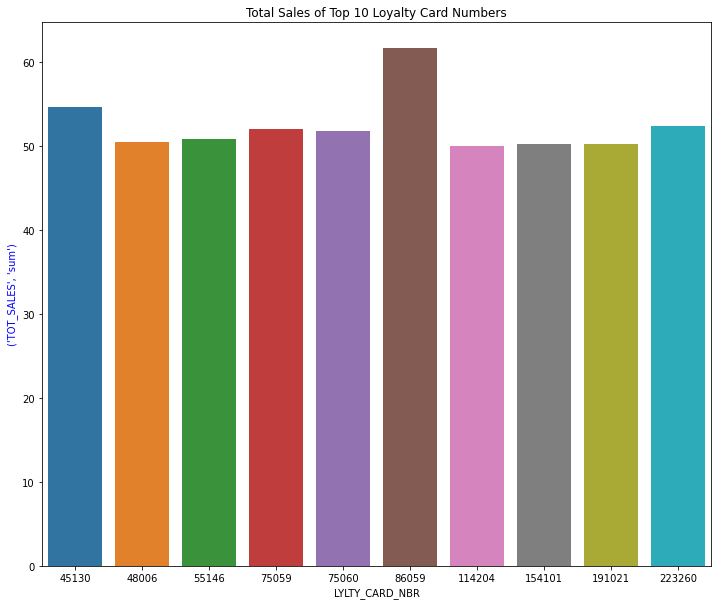

In [41]:
#Now, let's graph the top loyalty card number purchases
plt.figure(figsize=(12,10))
plt.ylabel('Total Sales Sum', color = 'blue')
plt.xlabel('Loyalty Card Number')
plt.title('Total Sales of Top 10 Loyalty Card Numbers')
ax = sns.barplot(x = "LYLTY_CARD_NBR", y = ("TOT_SALES","sum"), data = top_ten_purchases)

In [42]:
#Exploring which stores have the most number of transactions
top_stores = merged.groupby(['STORE_NBR', 'PREMIUM_CUSTOMER', 'LIFESTAGE'])['LYLTY_CARD_NBR'].agg(['count']).reset_index().sort_values(by='count', ascending = False)
top_stores

,STORE_NBR,PREMIUM_CUSTOMER,LIFESTAGE,count
785,43,Budget,OLDER FAMILIES,62
1704,93,Budget,OLDER FAMILIES,60
1160,63,Budget,OLDER FAMILIES,56
73,4,Mainstream,RETIREES,55
1931,105,Budget,OLDER FAMILIES,55
...,...,...,...,...
2527,136,Premium,NEW FAMILIES,1
936,51,Budget,NEW FAMILIES,1
940,51,Budget,YOUNG FAMILIES,1
4611,250,Budget,NEW FAMILIES,1


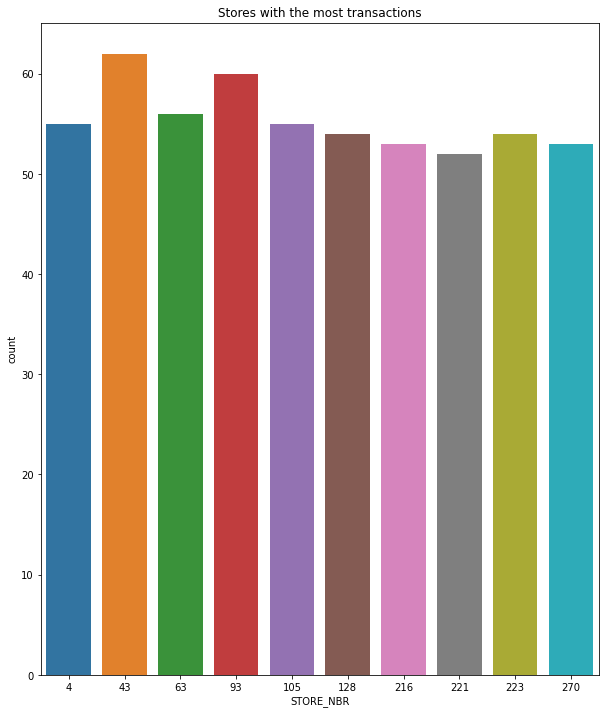

In [43]:
plt.figure(figsize = (10,12))
plt.title('Stores with the most transactions')
ax = sns.barplot(x='STORE_NBR', y= 'count', data = top_stores.head(10))

In [44]:
chip_wgt = merged['PROD_NAME'].str.extract('(\d+)')
chip_wgt.rename(columns = {0:'gram_weight'}, inplace = True)
chip_wgt['gram_weight'] = chip_wgt['gram_weight'].astype('int')
count_chip_wgt = chip_wgt.groupby(['gram_weight'])['gram_weight'].agg(['count']).reset_index().sort_values(by='count', ascending = False)
count_chip_wgt

,gram_weight,count
4,175,15493
3,170,15413
0,110,9693
1,150,9580
6,330,3197
5,200,3004
2,160,2970


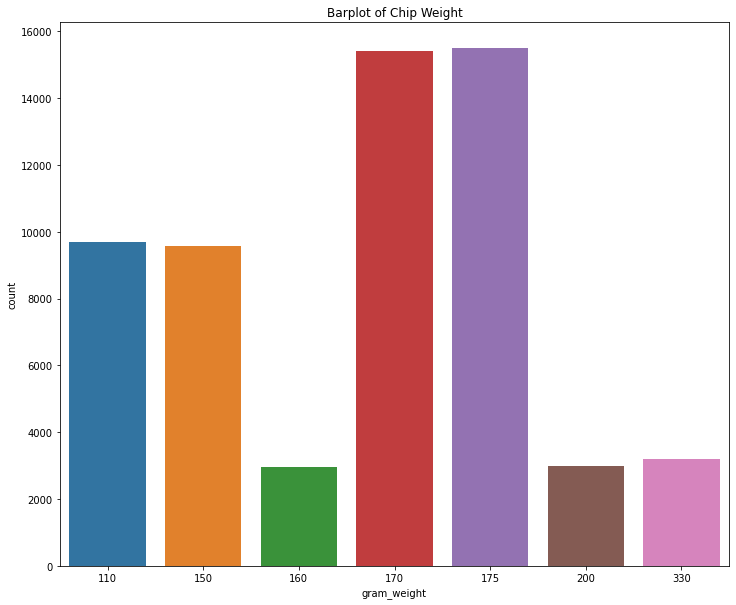

In [45]:
plt.figure(figsize = (12, 10))
plt.title('Barplot of Chip Weight')
ax = sns.barplot(x = 'gram_weight', y = 'count', data = count_chip_wgt)

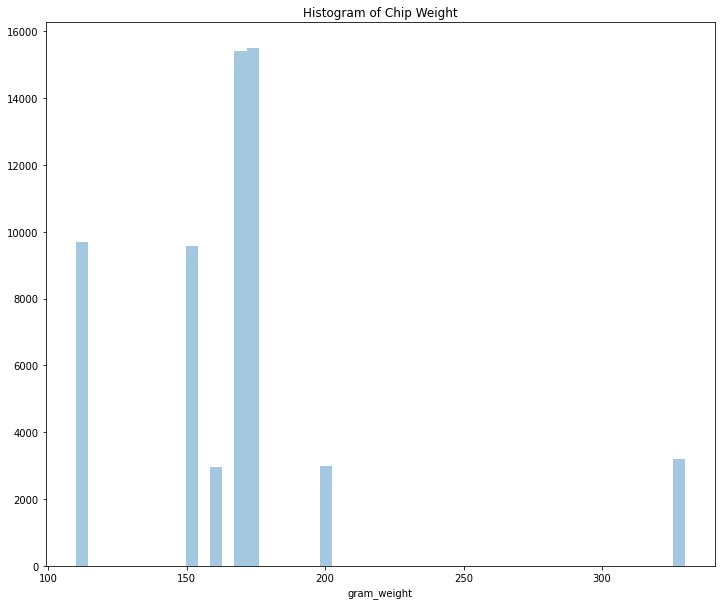

In [46]:
plt.figure(figsize = (12,10))
plt.title('Histogram of Chip Weight')
ax = sns.distplot(a = chip_wgt['gram_weight'], kde = False)
#There are discrete chip weights 
#I'm assuming that in a histogram there is a range of values, which is why it peaks above 80k 

In [47]:
#Min gram weight
min_wgt = count_chip_wgt['gram_weight'].min()
min_wgt

110

In [48]:
#Max gram weight
max_wgt = count_chip_wgt['gram_weight'].max()
max_wgt

330

In [49]:
#Exploring popular chip brands
popular_brands = merged.groupby(['PROD_NAME']).count().reset_index().sort_values(by = 'TOT_SALES', ascending = False)
popular_brands

,PROD_NAME,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,PRICE
9,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3296,3296,3296,3296,3296,3296,3296,3296,3296,3296
2,Cobs Popd Swt/Chlli &Sr/Cream Chips 110g,3269,3269,3269,3269,3269,3269,3269,3269,3269,3269
0,Cobs Popd Sea Salt Chips 110g,3265,3265,3265,3265,3265,3265,3265,3265,3265,3265
19,Thins Potato Chips Hot & Spicy 175g,3229,3229,3229,3229,3229,3229,3229,3229,3229,3229
3,Doritos Corn Chips Cheese Supreme 170g,3217,3217,3217,3217,3217,3217,3217,3217,3217,3217
10,Smiths Crinkle Chips Salt & Vinegar 330g,3197,3197,3197,3197,3197,3197,3197,3197,3197,3197
16,Thins Chips Light& Tangy 175g,3188,3188,3188,3188,3188,3188,3188,3188,3188,3188
4,Doritos Corn Chips Nacho Cheese 170g,3160,3160,3160,3160,3160,3160,3160,3160,3160,3160
1,Cobs Popd Sour Crm &Chives Chips 110g,3159,3159,3159,3159,3159,3159,3159,3159,3159,3159
7,Kettle Tortilla ChpsBtroot&Ricotta 150g,3146,3146,3146,3146,3146,3146,3146,3146,3146,3146


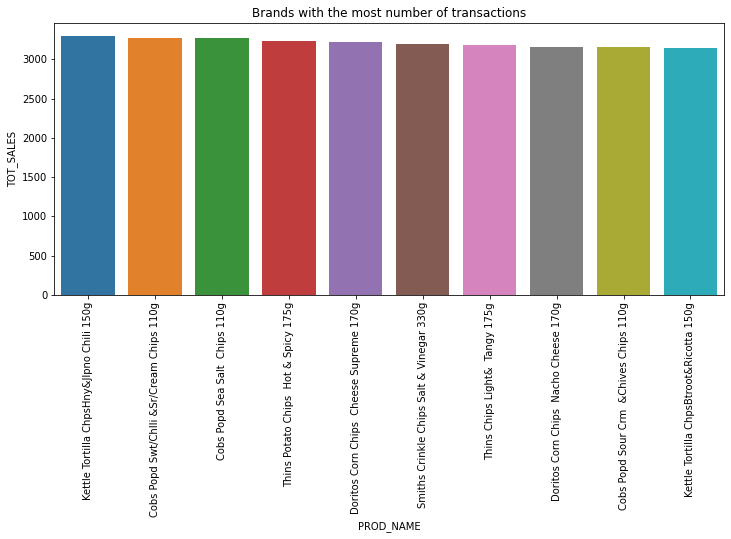

In [50]:
plt.figure(figsize=(12, 5))
plt.xticks(rotation = 90)
plt.title('Brands with the most number of transactions')
ax = sns.barplot(x = "PROD_NAME", y = "TOT_SALES", data = popular_brands.head(10))

In [51]:
#Let's look at the transaction by date
df_for_date = merged.groupby(['DATE']).count()
dates = pd.date_range(start='7/1/2018', periods = len(df_for_date), freq = 'D')
df_for_date['the_date'] = dates
df_for_date

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PRICE,the_date
DATE,,,,,,,,,,,
43282,145,145,145,145,145,145,145,145,145,145,2018-07-01
43283,153,153,153,153,153,153,153,153,153,153,2018-07-02
43284,160,160,160,160,160,160,160,160,160,160,2018-07-03
43285,150,150,150,150,150,150,150,150,150,150,2018-07-04
43286,156,156,156,156,156,156,156,156,156,156,2018-07-05
...,...,...,...,...,...,...,...,...,...,...,...
43642,144,144,144,144,144,144,144,144,144,144,2019-06-25
43643,144,144,144,144,144,144,144,144,144,144,2019-06-26
43644,190,190,190,190,190,190,190,190,190,190,2019-06-27


In [52]:
df_for_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 43282 to 43646
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   LYLTY_CARD_NBR    364 non-null    int64         
 1   LIFESTAGE         364 non-null    int64         
 2   PREMIUM_CUSTOMER  364 non-null    int64         
 3   STORE_NBR         364 non-null    int64         
 4   TXN_ID            364 non-null    int64         
 5   PROD_NBR          364 non-null    int64         
 6   PROD_NAME         364 non-null    int64         
 7   PROD_QTY          364 non-null    int64         
 8   TOT_SALES         364 non-null    int64         
 9   PRICE             364 non-null    int64         
 10  the_date          364 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(10)
memory usage: 34.1 KB


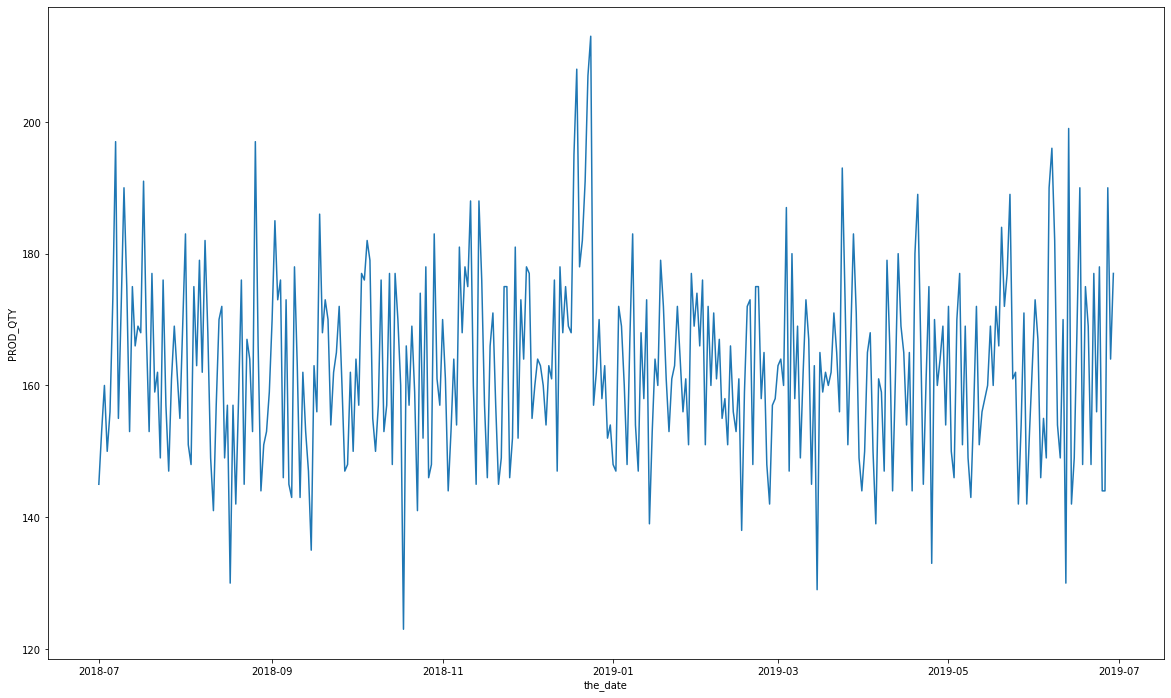

In [53]:
plt.figure(figsize=(20,12))
ax = sns.lineplot(x='the_date', y = 'PROD_QTY', data = df_for_date)
#There is clearly a spike in transactions towards the holidays 
#I don't see an outlier in the date

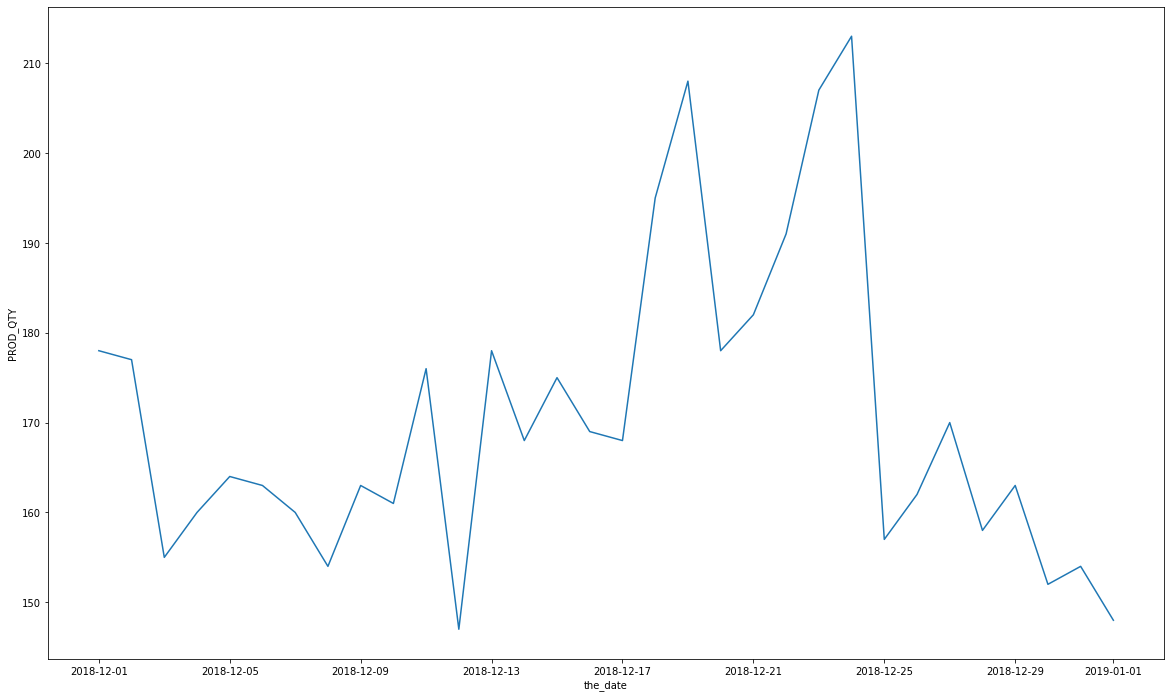

In [54]:
specific_date_range = df_for_date[(df_for_date['the_date'] >= '2018-12-01') & (df_for_date['the_date']<= '2019-01-01')]
plt.figure(figsize=(20,12))
ax = sns.lineplot(x='the_date', y = 'PROD_QTY', data = specific_date_range)